# Evaluate and Test Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset, SequentialSampler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import random
import os
import copy
import warnings
from functools import partial

from utils import pad_and_sort_batch, preprocess_for_batch, pad_or_truncate, pad_and_truncate_hierarchical, preprocess_for_batch_hierarchical

warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.__version__

'1.0.1'

In [2]:
# set random seeds to keep the results identical
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    setup_seed(torch.initial_seed() + worker_id)
    
GLOBAL_SEED = 2019
setup_seed(GLOBAL_SEED)

In [3]:
base_dir = './'

## Load data for testing

In [4]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.features[idx].size(0) > 0:
            features = self.features[idx]
        else:
            features = torch.LongTensor([1])
        return features, self.labels[idx], max(len(self.features[idx]), 1)
    
def prepare_data_for_test(data_pth, batch_size=32, multiclass=False, truncate=False, maxlen=500):
    X_test = pd.read_hdf(data_pth+'X_test.h5', key='s')
    y_test = pd.read_hdf(data_pth+'y_test.h5', key='s')
    if multiclass:
        y_test = y_test-1
    X_test_tensors = [torch.tensor(x, dtype=torch.int64) for x in X_test]
    y_test_tensors = [torch.tensor(y, dtype=torch.int64) for y in y_test]
    if truncate:
        X_test_tensors = [pad_or_truncate(x, maxlen=maxlen, pad=False) for x in X_test_tensors] # just truncate no padding to save GPU memory
    test_dataset = CustomDataset(X_test_tensors, y_test_tensors)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_and_sort_batch)
    return test_dataloader


class CustomDatasetHierarchical(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# def prepare_data_for_test_hierarchical(data_pth, batch_size=32, multiclass=False, max_sen_len=50, max_sen_num=50):
#     X_test = pd.read_hdf(data_pth+'X_test.h5', key='s')
#     y_test = pd.read_hdf(data_pth+'y_test.h5', key='s')
#     if multiclass:
#         y_test = y_test-1

#     test_dataset = CustomDatasetHierarchical(X_test, y_test)

#     test_dataloader = DataLoader(test_dataset, 
#                                   batch_size=batch_size, 
#                                   shuffle=False, 
#                                   collate_fn=partial(pad_and_truncate_hierarchical, MAX_SEN_LEN=max_sen_len,                                                     MAX_SEN_NUM=max_sen_num), 
#                                   )
#     return test_dataloader


def prepare_data_for_test_hierarchical(data_pth, batch_size=32, multiclass=False, max_sen_len=50, max_sen_num=50):
    X_test = pd.read_hdf(data_pth+'X_test.h5', key='s')
    y_test = pd.read_hdf(data_pth+'y_test.h5', key='s')
    if multiclass:
        y_test = y_test-1

    X_test_sorted, y_test_sorted = preprocess_for_batch_hierarchical(X_test, y_test, batch_size)

    test_dataset = CustomDatasetHierarchical(X_test_sorted, y_test_sorted)

    test_dataloader = DataLoader(test_dataset, 
                                  batch_size=batch_size, 
                                  sampler=SequentialSampler(test_dataset), 
                                  shuffle=False, 
                                  collate_fn=partial(pad_and_truncate_hierarchical, MAX_SEN_LEN=max_sen_len,                                                     MAX_SEN_NUM=max_sen_num))
    return test_dataloader

In [5]:
yelp_polarity_data = prepare_data_for_test(base_dir + 'dataset/yelp_review_polarity_csv/',  batch_size=16, multiclass=False, truncate=False, maxlen=500)
yelp_full_data = prepare_data_for_test(base_dir + 'dataset/yelp_review_full_csv/',  batch_size=16, multiclass=True, truncate=False, maxlen=500)
imdb_data = prepare_data_for_test(base_dir + 'dataset/IMDB/',  batch_size=16, multiclass=False, truncate=False, maxlen=500)
douban_data = prepare_data_for_test(base_dir + 'dataset/Douban/',  batch_size=16, multiclass=False, truncate=False, maxlen=500)

In [6]:
yelp_polarity_hierarchical_data = prepare_data_for_test_hierarchical(base_dir + 'dataset_hierarchical/yelp_review_polarity_csv/',  batch_size=32, multiclass=False)

yelp_full_hierarchical_data = prepare_data_for_test_hierarchical(base_dir + 'dataset_hierarchical/yelp_review_full_csv/',  batch_size=32, multiclass=True)
imdb_hierarchical_data = prepare_data_for_test_hierarchical(base_dir + 'dataset_hierarchical/IMDB/',  batch_size=32, multiclass=False)
douban_hierarchical_data = prepare_data_for_test_hierarchical(base_dir + 'dataset_hierarchical/Douban/',  batch_size=32, multiclass=False, max_sen_len=25, max_sen_num=25)

## Load trained models

In [8]:
from AttentionBiLSTM import AttnBiLSTM
from AvgBiLSTM import AvgBiLSTM
from SIAttentionBiLSTM import SIAttentionBiLSTM
from HAN import HAN
from Transformer import Transformer

In [9]:
def load_AttnBiLSTM_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    model = AttnBiLSTM(output_size=output_size, hidden_size=parameters['hidden_size'], embedding=parameters['embedding'], method=parameters['att_method'], rnn_dropout=parameters['rnn_dropout'], embedding_dropout=parameters['embedding_dropout'], context_dropout=parameters['context_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'])
    return model, history

def load_Transformer_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    architecture = (parameters['n_layers'], parameters['d_model'], parameters['d_ff'], parameters['n_heads'], parameters['d_k'], parameters['d_v'])
    model = Transformer(output_size=output_size, architecture=architecture, embedding=parameters['embedding'], method=parameters['final_att_method'], maxpos=500, embedding_dropout=parameters['embedding_dropout'], multihead_dropout=parameters['multihead_dropout'], att_dropout=parameters['att_dropout'], feedforward_dropout=parameters['feedforward_dropout'], final_dropout=parameters['final_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'])
    return model, history

def load_SIAttentionBiLSTM_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    model = SIAttentionBiLSTM(output_size=output_size, n_layers=parameters['n_layers'], d_model=parameters['d_model'], d_k=parameters['d_k'], d_v=parameters['d_v'], n_heads=parameters['n_heads'], hidden_size=parameters['hidden_size'], embedding=parameters['embedding'], method=parameters['att_method'], rnn_dropout=parameters['rnn_dropout'], embedding_dropout=parameters['embedding_dropout'], multihead_dropout=parameters['multihead_dropout'], context_dropout=parameters['context_dropout'], transformer_dropout=parameters['transformer_dropout'], inter_att_dropout=parameters['inter_att_dropout'], self_att_dropout=parameters['self_att_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'])
    return model, history

def load_HAN_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    model = HAN(output_size=output_size, hidden_size=parameters['hidden_size'], embedding=parameters['embedding'], method=parameters['att_method'], rnn_dropout=parameters['rnn_dropout'], embedding_dropout=parameters['embedding_dropout'], word_dropout=parameters['word_dropout'], sent_dropout=parameters['sent_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'], strict=False)
    return model, history

def load_AvgBiLSTM_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    model = AvgBiLSTM(output_size=output_size, hidden_size=parameters['hidden_size'], embedding=parameters['embedding'], rnn_dropout=parameters['rnn_dropout'], embedding_dropout=parameters['embedding_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'])
    return model, history

In [10]:
from IPython.core.debugger import set_trace
def predict(model, data_loader, input_len=True, multiclass=False, hierarchical=False):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        with tqdm(total=len(data_loader.dataset)) as pbar:
            for idx, batch in enumerate(data_loader):
                if hierarchical:
                    input_batch, labels = batch
                    if not multiclass:
                        labels = labels.float()
                    else:
                        labels = labels.squeeze()
                else:
                    input_batch, labels, lengths = batch
                if not multiclass and not hierarchical:
                    labels = labels.float().unsqueeze(1) # polarity
                if input_len:
                    output = model(input_batch, lengths)
                else:
                    output = model(input_batch)
                y_true.append(labels.cpu())
                y_pred.append(output.cpu())
                pbar.update(input_batch.size(0))
    return torch.cat(y_pred), torch.cat(y_true)
    return torch.tensor(np.array(y_pred).reshape(-1, y_pred[0].shape[-1])), torch.tensor(np.array(y_true).reshape(-1, y_pred[0].shape[-1]))

## Loss & Accuracy & Precision & Recall & F1 score & roc_auc_score

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
def evaluate(y_pred, y_true, multiclass=False, model_name='', dataset=''):
    if multiclass:
        criterion = nn.CrossEntropyLoss()
        loss = criterion(y_pred, y_true).item()
        _, preds = torch.max(y_pred, 1)
        accuracy = (preds == y_true).float().mean().item()
        return pd.Series([model_name, dataset, accuracy, loss], index=['model', 'dataset', 'accuracy', 'loss'])
    else:
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_pred, y_true).item()
        accuracy = (y_pred>0).eq(y_true>0).float().mean().item()
        f1 = f1_score(y_true, y_pred>0)
        precision = precision_score(y_true, y_pred>0)
        recall = recall_score(y_true, y_pred>0)
        auc = roc_auc_score(y_true, y_pred)
        return pd.Series([model_name, dataset, accuracy, loss, f1, precision, recall, auc], index=['model', 'dataset', 'accuracy', 'loss', 'f1', 'precision', 'recall', 'auc'])

## Evaluate all the models

In [12]:
#evaluate_df = pd.DataFrame()

In [13]:
evaluate_df = pd.read_csv('evaluate_df.csv')

In [13]:
os.listdir('./model save/Inter-Attention-BiLSTM')

['Attention-c-query-BiLSTM-on-Douban.pth',
 'Attention-c-query-BiLSTM-on-IMDB.pth',
 'Attention-c-query-BiLSTM-on-Yelp-Full.pth',
 'Attention-c-query-BiLSTM-on-Yelp-Polarity.pth',
 'Attention-h-query-BiLSTM-on-Douban.pth',
 'Attention-h-query-BiLSTM-on-IMDB.pth',
 'Attention-h-query-BiLSTM-on-Yelp-Full.pth',
 'Attention-h-query-BiLSTM-on-Yelp-Polarity.pth',
 'Attention-independent-query-BiLSTM-on-Douban.pth',
 'Attention-independent-query-BiLSTM-on-IMDB.pth',
 'Attention-independent-query-BiLSTM-on-Yelp-Full.pth',
 'Attention-independent-query-BiLSTM-on-Yelp-Polarity.pth',
 'Attention-no-query-BiLSTM-on-Douban.pth',
 'Attention-no-query-BiLSTM-on-IMDB.pth',
 'Attention-no-query-BiLSTM-on-Yelp-Full.pth',
 'Attention-no-query-BiLSTM-on-Yelp-Polarity.pth']

In [14]:
os.listdir('./model save/Transformer')

['Transformer-on-Douban.pth',
 'Transformer-on-IMDB.pth',
 'Transformer-on-Yelp-Full.pth',
 'Transformer-on-Yelp-Polarity.pth']

In [15]:
os.listdir('./model save/Self-Inter-Attention-BiLSTM')

['Self-Inter-Attention-BiLSTM-on-Douban.pth',
 'Self-Inter-Attention-BiLSTM-on-IMDB.pth',
 'Self-Inter-Attention-BiLSTM-on-Yelp-Full.pth',
 'Self-Inter-Attention-BiLSTM-on-Yelp-Polarity.pth']

In [16]:
os.listdir('./model save/HAN/')

['Hierarchical-Attention-Networks-on-Douban.pth',
 'Hierarchical-Attention-Networks-on-IMDB.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Full.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Polarity.pth']

In [17]:
os.listdir('./model save/Avg-BiLSTM')

['Avg-BiLSTM-on-Douban.pth',
 'Avg-BiLSTM-on-IMDB.pth',
 'Avg-BiLSTM-on-Yelp-Full.pth',
 'Avg-BiLSTM-on-Yelp-Polarity.pth']

### Avg-BiLSTM

In [17]:
avg_bilstm_on_douban, avg_bilstm_on_douban_history = load_AvgBiLSTM_model(base_dir+'model save/Avg-BiLSTM/' + 'Avg-BiLSTM-on-Douban.pth')
y_pred, y_true = predict(avg_bilstm_on_douban, douban_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Avg-BiLSTM-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:42<00:00, 2368.30it/s]


In [18]:
avg_bilstm_on_imdb, avg_bilstm_on_imdb_history = load_AvgBiLSTM_model(base_dir+'model save/Avg-BiLSTM/' + 'Avg-BiLSTM-on-IMDB.pth')
y_pred, y_true = predict(avg_bilstm_on_imdb, imdb_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Avg-BiLSTM-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 521.55it/s]


In [19]:
avg_bilstm_on_yelp_polarity, avg_bilstm_on_yelp_polarity_history = load_AvgBiLSTM_model(base_dir+'model save/Avg-BiLSTM/' + 'Avg-BiLSTM-on-Yelp-Polarity.pth')
y_pred, y_true = predict(avg_bilstm_on_yelp_polarity, yelp_polarity_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Avg-BiLSTM-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [00:54<00:00, 699.41it/s]


In [20]:
avg_bilstm_on_yelp_full, avg_bilstm_on_yelp_full_history = load_AvgBiLSTM_model(base_dir+'model save/Avg-BiLSTM/' + 'Avg-BiLSTM-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(avg_bilstm_on_yelp_full, yelp_full_data, multiclass=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Avg-BiLSTM-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:11<00:00, 697.27it/s]


### Inter-Attention-BiLSTM

#### c-query

In [31]:
attn_bilstm_c_query_on_douban, attn_bilstm_c_query_on_douban_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-c-query-BiLSTM-on-Douban.pth')
y_pred, y_true = predict(attn_bilstm_c_query_on_douban, douban_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-c-query-BiLSTM-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:54<00:00, 1828.70it/s]


In [32]:
attn_bilstm_c_query_on_imdb, attn_bilstm_c_query_on_imdb_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-c-query-BiLSTM-on-IMDB.pth')
y_pred, y_true = predict(attn_bilstm_c_query_on_imdb, imdb_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-c-query-BiLSTM-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 354.94it/s]


In [34]:
attn_bilstm_c_query_on_yelp_polarity, attn_bilstm_c_query_on_yelp_polarity_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-c-query-BiLSTM-on-Yelp-Polarity.pth')
y_pred, y_true = predict(attn_bilstm_c_query_on_yelp_polarity, yelp_polarity_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-c-query-BiLSTM-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [01:14<00:00, 456.00it/s]


In [35]:
attn_bilstm_c_query_on_yelp_full, attn_bilstm_c_query_on_yelp_full_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-c-query-BiLSTM-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(attn_bilstm_c_query_on_yelp_full, yelp_full_data, multiclass=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-c-query-BiLSTM-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 542.17it/s]


#### h-query

In [37]:
attn_bilstm_h_query_on_douban, attn_bilstm_h_query_on_douban_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-h-query-BiLSTM-on-Douban.pth')
y_pred, y_true = predict(attn_bilstm_h_query_on_douban, douban_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-h-query-BiLSTM-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:56<00:00, 1762.88it/s]


In [38]:
attn_bilstm_h_query_on_imdb, attn_bilstm_h_query_on_imdb_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-h-query-BiLSTM-on-IMDB.pth')
y_pred, y_true = predict(attn_bilstm_h_query_on_imdb, imdb_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-h-query-BiLSTM-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 376.54it/s]


In [39]:
attn_bilstm_h_query_on_yelp_polarity, attn_bilstm_h_query_on_yelp_polarity_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-h-query-BiLSTM-on-Yelp-Polarity.pth')
y_pred, y_true = predict(attn_bilstm_h_query_on_yelp_polarity, yelp_polarity_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-h-query-BiLSTM-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [01:14<00:00, 509.71it/s]


In [41]:
attn_bilstm_h_query_on_yelp_full, attn_bilstm_h_query_on_yelp_full_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-h-query-BiLSTM-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(attn_bilstm_h_query_on_yelp_full, yelp_full_data, multiclass=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-h-query-BiLSTM-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 513.61it/s]


#### independent parameters query

In [42]:
attn_bilstm_independent_query_on_douban, attn_bilstm_independent_query_on_douban_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-independent-query-BiLSTM-on-Douban.pth')
y_pred, y_true = predict(attn_bilstm_independent_query_on_douban, douban_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-independent-query-BiLSTM-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:55<00:00, 1792.79it/s]


In [18]:
attn_bilstm_independent_query_on_imdb, attn_bilstm_independent_query_on_imdb_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-independent-query-BiLSTM-on-IMDB.pth')
y_pred, y_true = predict(attn_bilstm_independent_query_on_imdb, imdb_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-independent-query-BiLSTM-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 373.02it/s]


In [19]:
attn_bilstm_independent_query_on_yelp_polarity, attn_bilstm_independent_query_on_yelp_polarity_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-independent-query-BiLSTM-on-Yelp-Polarity.pth')
y_pred, y_true = predict(attn_bilstm_independent_query_on_yelp_polarity, yelp_polarity_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-independent-query-BiLSTM-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [01:14<00:00, 511.79it/s]


In [20]:
attn_bilstm_independent_query_on_yelp_full, attn_bilstm_independent_query_on_yelp_full_history = load_AttnBiLSTM_model(base_dir+'model save/Inter-Attention-BiLSTM/' + 'Attention-independent-query-BiLSTM-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(attn_bilstm_independent_query_on_yelp_full, yelp_full_data, multiclass=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Inter-Attention-independent-query-BiLSTM-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 501.79it/s]


### Transformer

In [16]:
transformer_on_douban, transformer_on_douban_history = load_Transformer_model(base_dir+'model save/Transformer/' + 'Transformer-on-Douban.pth')
y_pred, y_true = predict(transformer_on_douban, douban_data, input_len=False)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Transformer-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:33<00:00, 1072.14it/s]


In [27]:
transformer_on_imdb, transformer_on_imdb_history = load_Transformer_model(base_dir+'model save/Transformer/' + 'Transformer-on-IMDB.pth')
y_pred, y_true = predict(transformer_on_imdb, imdb_data, input_len=False)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Transformer-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 116.43it/s]


In [28]:
transformer_on_yelp_polarity, transformer_on_yelp_polarity_history = load_Transformer_model(base_dir+'model save/Transformer/' + 'Transformer-on-Yelp-Polarity.pth')
y_pred, y_true = predict(transformer_on_yelp_polarity, yelp_polarity_data, input_len=False)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Transformer-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [02:58<00:00, 213.16it/s]


In [29]:
transformer_on_yelp_full, transformer_on_yelp_full_history = load_Transformer_model(base_dir+'model save/Transformer/' + 'Transformer-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(transformer_on_yelp_full, yelp_full_data, multiclass=True, input_len=False)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Transformer-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:56<00:00, 211.30it/s]


### Self-Inter-Attention-BiLSTM

In [21]:
si_attn_bilstm_on_douban, si_attn_bilstm_on_douban_history = load_SIAttentionBiLSTM_model(base_dir+'model save/Self-Inter-Attention-BiLSTM/' + 'Self-Inter-Attention-BiLSTM-on-Douban.pth')
y_pred, y_true = predict(si_attn_bilstm_on_douban, douban_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Self-Inter-Attention-BiLSTM-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:57<00:00, 1745.89it/s]


In [22]:
si_attn_bilstm_on_imdb, si_attn_bilstm_on_imdb_history = load_SIAttentionBiLSTM_model(base_dir+'model save/Self-Inter-Attention-BiLSTM/' + 'Self-Inter-Attention-BiLSTM-on-IMDB.pth')
y_pred, y_true = predict(si_attn_bilstm_on_imdb, imdb_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Self-Inter-Attention-BiLSTM-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 243.38it/s]


In [23]:
si_attn_bilstm_on_yelp_polarity, si_attn_bilstm_on_yelp_polarity_history = load_SIAttentionBiLSTM_model(base_dir+'model save/Self-Inter-Attention-BiLSTM/' + 'Self-Inter-Attention-BiLSTM-on-Yelp-Polarity.pth')
y_pred, y_true = predict(si_attn_bilstm_on_yelp_polarity, yelp_polarity_data)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Self-Inter-Attention-BiLSTM-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 38000/38000 [01:34<00:00, 402.86it/s]


In [25]:
si_attn_bilstm_on_yelp_full, si_attn_bilstm_on_yelp_full_history = load_SIAttentionBiLSTM_model(base_dir+'model save/Self-Inter-Attention-BiLSTM/' + 'Self-Inter-Attention-BiLSTM-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(si_attn_bilstm_on_yelp_full, yelp_full_data, multiclass=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Self-Inter-Attention-BiLSTM-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:04<00:00, 402.08it/s]


### Hierarchical-Attention-Networks

In [39]:
os.listdir('./model save/HAN/')

['Hierarchical-Attention-Networks-on-Douban.pth',
 'Hierarchical-Attention-Networks-on-IMDB.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Full.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Polarity.pth']

In [43]:
hierarchical_on_douban, hierarchical_on_douban_history = load_HAN_model(base_dir+'model save/HAN/' + 'Hierarchical-Attention-Networks-on-Douban.pth')
y_pred, y_true = predict(hierarchical_on_douban, douban_hierarchical_data, input_len=False, hierarchical=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Hierarchical-on-Douban', dataset='Douban'), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:38<00:00, 1019.43it/s]


In [47]:
hierarchical_on_imdb, hierarchical_on_imdb_history = load_HAN_model(base_dir+'model save/HAN/' + 'Hierarchical-Attention-Networks-on-IMDB.pth')
y_pred, y_true = predict(hierarchical_on_imdb, imdb_hierarchical_data, input_len=False, hierarchical=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Hierarchical-on-IMDB', dataset='IMDB'), ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 4992/4992 [00:21<00:00, 224.19it/s]


In [18]:
hierarchical_on_yelp_polarity, hierarchical_on_yelp_polarity_history = load_HAN_model(base_dir+'model save/HAN/' + 'Hierarchical-Attention-Networks-on-Yelp-Polarity.pth')
y_pred, y_true = predict(hierarchical_on_yelp_polarity, yelp_polarity_hierarchical_data, input_len=False, hierarchical=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Hierarchical-on-Yelp-Polarity', dataset='Yelp-Polarity'), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 37984/37984 [00:44<00:00, 848.28it/s]


In [13]:
hierarchical_on_yelp_full, hierarchical_on_yelp_full_history = load_HAN_model(base_dir+'model save/HAN/' + 'Hierarchical-Attention-Networks-on-Yelp-Full.pth', output_size=5)
y_pred, y_true = predict(hierarchical_on_yelp_full, yelp_full_hierarchical_data, multiclass=True, input_len=False, hierarchical=True)
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name='Hierarchical-on-Yelp-Full', dataset='Yelp-Full', multiclass=True), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████| 49984/49984 [01:00<00:00, 862.84it/s]


## Summary

In [28]:
evaluate_df.to_csv('evaluate_df.csv', index=False)

In [21]:
evaluate_df.sort_values(by='dataset').set_index(['dataset', 'model'])

accuracy  \
dataset       model                                                          
Douban        Avg-BiLSTM-on-Douban                                0.839540   
              Hierarchical-on-Douban                              0.845100   
              Inter-Attention-independent-query-BiLSTM-on-Douban  0.840280   
              Inter-Attention-h-query-BiLSTM-on-Douban            0.841990   
              Inter-Attention-c-query-BiLSTM-on-Douban            0.839640   
              Transformer-on-Douban                               0.802830   
              Self-Inter-Attention-BiLSTM-on-Douban               0.840970   
IMDB          Inter-Attention-h-query-BiLSTM-on-IMDB              0.920000   
              Inter-Attention-c-query-BiLSTM-on-IMDB              0.921400   
              Hierarchical-on-IMDB                                0.924479   
              Self-Inter-Attention-BiLSTM-on-IMDB                 0.919400   
              Inter-Attention-independent-query-BiLSTM-on-IMDB    0.920200   
              Avg-BiLSTM-on-IMDB                                  0.918600   
              Transformer-on-IMDB                                 0.907200   
Yelp-Full     Self-Inter-Attention-BiLSTM-on-Yelp-Full            0.662600   
              Inter-Attention-c-query-BiLSTM-on-Yelp-Full         0.659660   
              Avg-BiLSTM-on-Yelp-Full                             0.666760   
              Hierarchical-on-Yelp-Full                           0.673055   
              Inter-Attention-h-query-BiLSTM-on-Yelp-Full         0.678240   
              Inter-Attention-independent-query-BiLSTM-on-Yel...  0.675160   
              Transformer-on-Yelp-Full                            0.600840   
Yelp-Polarity Hierarchical-on-Yelp-Polarity                       0.967750   
              Self-Inter-Attention-BiLSTM-on-Yelp-Polarity        0.965684   
              Inter-Attention-independent-query-BiLSTM-on-Yel...  0.967658   
              Inter-Attention-h-query-BiLSTM-on-Yelp-Polarity     0.966974   
              Inter-Attention-c-query-BiLSTM-on-Yelp-Polarity     0.964553   
              Transformer-on-Yelp-Polarity                        0.935447   
              Avg-BiLSTM-on-Yelp-Polarity                         0.966711   

                                                                       auc  \
dataset       model                                                          
Douban        Avg-BiLSTM-on-Douban                                0.906459   
              Hierarchical-on-Douban                              0.926152   
              Inter-Attention-independent-query-BiLSTM-on-Douban  0.922254   
              Inter-Attention-h-query-BiLSTM-on-Douban            0.922871   
              Inter-Attention-c-query-BiLSTM-on-Douban            0.921216   
              Transformer-on-Douban                               0.884197   
              Self-Inter-Attention-BiLSTM-on-Douban               0.920650   
IMDB          Inter-Attention-h-query-BiLSTM-on-IMDB              0.972595   
              Inter-Attention-c-query-BiLSTM-on-IMDB              0.975055   
              Hierarchical-on-IMDB                                0.977709   
              Self-Inter-Attention-BiLSTM-on-IMDB                 0.970322   
              Inter-Attention-independent-query-BiLSTM-on-IMDB    0.972161   
              Avg-BiLSTM-on-IMDB                                  0.969562   
              Transformer-on-IMDB                                 0.967122   
Yelp-Full     Self-Inter-Attention-BiLSTM-on-Yelp-Full                 NaN   
              Inter-Attention-c-query-BiLSTM-on-Yelp-Full              NaN   
              Avg-BiLSTM-on-Yelp-Full                                  NaN   
              Hierarchical-on-Yelp-Full                                NaN   
              Inter-Attention-h-query-BiLSTM-on-Yelp-Full              NaN   
              Inter-Attention-independent-query-BiLSTM-on-Yel...       NaN   
         

In [22]:
df = evaluate_df.set_index('model')

In [23]:
df.index = df.index.str.extract('(.*)-on')[0]

In [24]:
douban_accuracy = df[df['dataset']=='Douban']['accuracy']
yelp_full_accuracy = df[df['dataset']=='Yelp-Full']['accuracy']
yelp_polarity_accuracy = df[df['dataset']=='Yelp-Polarity']['accuracy']
imdb_accuracy = df[df['dataset']=='IMDB']['accuracy']

In [25]:
accuracy_df = pd.concat([douban_accuracy, yelp_full_accuracy, yelp_polarity_accuracy, imdb_accuracy], axis=1)
accuracy_df.columns = ['Douban', 'Yelp-Full', 'Yelp-Polarity', 'IMDB']
accuracy_df.index.name=None
accuracy_df

,Douban,Yelp-Full,Yelp-Polarity,IMDB
Avg-BiLSTM,0.83954,0.666760,0.966711,0.918600
Hierarchical,0.84510,0.673055,0.967750,0.924479
Inter-Attention-c-query-BiLSTM,0.83964,0.659660,0.964553,0.921400
Inter-Attention-h-query-BiLSTM,0.84199,0.678240,0.966974,0.920000
Inter-Attention-independent-query-BiLSTM,0.84028,0.675160,0.967658,0.920200
Self-Inter-Attention-BiLSTM,0.84097,0.662600,0.965684,0.919400
Transformer,0.80283,0.600840,0.935447,0.907200


In [26]:
douban_loss= df[df['dataset']=='Douban']['loss']
yelp_full_loss = df[df['dataset']=='Yelp-Full']['loss']
yelp_polarity_loss = df[df['dataset']=='Yelp-Polarity']['loss']
imdb_loss = df[df['dataset']=='IMDB']['loss']

In [27]:
loss_df = pd.concat([douban_loss, yelp_full_loss, yelp_polarity_loss, imdb_loss], axis=1)
loss_df.columns = ['Douban', 'Yelp-Full', 'Yelp-Polarity', 'IMDB']
loss_df.index.name=None
loss_df

,Douban,Yelp-Full,Yelp-Polarity,IMDB
Avg-BiLSTM,0.447697,1.004622,0.226632,0.287007
Hierarchical,0.355895,0.751090,0.089756,0.199881
Inter-Attention-c-query-BiLSTM,0.374190,0.798322,0.109183,0.214704
Inter-Attention-h-query-BiLSTM,0.369975,0.752670,0.099442,0.312038
Inter-Attention-independent-query-BiLSTM,0.372822,0.762503,0.095921,0.294275
Self-Inter-Attention-BiLSTM,0.388087,0.824653,0.121675,0.259638
Transformer,0.432439,0.920770,0.162424,0.242542


# ROC Curve

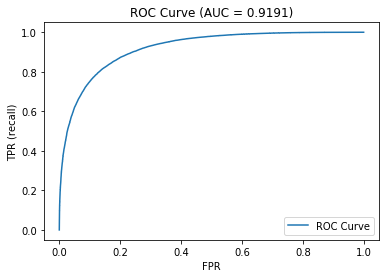

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
score = roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title('ROC Curve (AUC = {:.4f})'.format(score))
plt.legend(loc=4)
#plt.savefig('t.png')

## Confusion Matrix for Multiclass Classification (Yelp Full Dataset)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred>0)
print("Confusion matrix:\n{}".format(confusion))

## Plot train & validation loss and accuracy